# Current Amplifier Output Calibration

This script converts current_output_cal_functions into the OutputChannel() class for easier re-use (to cal Channel U and Channel V). Hopefully this serves as a starting point for my calibration routines, making them easier to convert to python-tcal

In [1]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import pyvisa as visa
from pathlib import Path
from scipy.interpolate import interp1d

from saveCalData import saveMeasurement
from progressbar import update_progress

In [2]:
def serialQry(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))
    return port.readline().decode('ascii').strip() #strip removes white space

def serialCmd(port, command):
    port.reset_input_buffer()
    port.write((command + '\n').encode('ascii'))

In [3]:
def rms(x):
    return np.sqrt(np.mean(x**2))

In [4]:
sr542 = serial.Serial(port='COM11', baudrate=115200, timeout=.5)
cs580 = serial.Serial(port='COM10', baudrate=9600, timeout=0.5)
rm = visa.ResourceManager()
rm.list_resources()
dvm = rm.open_resource('USB0::0x0957::0xB318::MY52449038::INSTR')

In [5]:
print(serialQry(sr542, '*IDN?'))
print(serialQry(cs580, '*IDN?'))
print(dvm.query('*IDN?'))

Stanford_Research_Systems, SR542, s/n00001007, v0.10
Stanford_Research_Systems,CS580,s/n137132,ver1.14
Agilent Technologies,34450A,MY52449038,00.56-00.63



# Define Cal Functions

In [10]:
class OutputChannel():
    def __init__(self, channel):
        if channel == 'U' or channel == 'V':
            self.channel = channel
        else:
            raise ValueError('Invalid channel assignment')
        
        # Default all values to ideal or nominal
        self.R = 0.1 # ohms
        self.Vref = 3.3 # volts
        self.dacBits = 12
        self.numCodes = 2**self.dacBits
        self.R_f = 10e3 # ohms
        self.R_in = 90.9e3 # ohms
        self.R_sense_nom = 0.1 # ohms
        self.HowlandGain = self.R_f/(self.R_in*self.R_sense_nom)
        self.LSB_A = self.Vref/self.numCodes*self.HowlandGain # LSB size, in Amps
        self.LUT = np.arange(0, self.numCodes, 1) # The Correction LUT
        self.idealCurrent = np.poly1d([self.Vref/self.numCodes, -self.Vref/2])*self.HowlandGain # linear current output defined by [slope, offset]
        self.allCodes = self.LUT
        self.txFun = self.idealCurrent(self.allCodes) # The Measured Transfer Function: txFun[code] = output (A)
        self.cald = False
        self.passed = False
        
    def CurrentToLsb(self, I_A):
        return I_A/self.LSB_A

    def LsbToCurrent(self, bits):
        return bits*self.LSB_A
        
    def SweepI_MeasV(self, I_init, I_final, I_step):

        I_sweep = np.arange(I_init, I_final + I_step, I_step)

        serialCmd(cs580, 'GAIN G50mA')
        serialCmd(cs580, f'CURR {I_init:.3f}')
        serialCmd(cs580, 'INPT OFF')
        serialCmd(cs580, 'SOUT ON')

        time.sleep(1.0)
        V_meas = []

        for curr in I_sweep:
            serialCmd(cs580, f'CURR {curr:.3f}')
            time.sleep(1.0)
            V_meas.append(float(dvm.query('MEAS:VOLT:DC? 0.1, 3e-5').strip('\n')))
            
            update_progress(len(V_meas) / len(I_sweep))

        serialCmd(cs580, 'CURR 0')
        serialCmd(cs580, 'SOUT OFF')

        coeffs, cov = np.polyfit(I_sweep, V_meas, 1, cov=True)
        fit = np.poly1d(coeffs)
        R_meas = coeffs[0]
        R_std = np.sqrt(np.diag(cov))[0]
        print(f'R = {R_meas:.5e} +- {R_std:.5e} Ohms')
        self.R = R_meas

        plt.plot(I_sweep, V_meas, '.')
        plt.plot(I_sweep, fit(I_sweep), label=f'fit: R={coeffs[0]:.6} Ohms')
        plt.xlabel('applied current (A)')
        plt.ylabel('meas voltage (V)')
        plt.legend()   
        plt.title('4 pt I-V Resistance Measurement')

    def MeasVoltageVsDacCode(self, codes):
        serialCmd(sr542, '$CEN ON')
        #time.sleep(30.0) # TODO: do I still need this?

        t0 = time.time()

        V_sense = []
        for dacCode in codes:
            if(self.channel=='U'):
                serialCmd(sr542, f'$SUV {dacCode}, 2048')
            elif(self.channel=='V'):
                serialCmd(sr542, f'$SUV 2048, {dacCode}')
            else:
                print('Invalid Channel')
                break

            time.sleep(0.1) #TODO: how long to sleep here?
            V = float(dvm.query('MEAS:VOLT:DC? 10, 1.5e-6')) #voltage measured across ~R_sense
            #print(f'{dacCode}, {V}')
            V_sense.append(V) 

            update_progress(len(V_sense) / len(codes))
            
        # Zero the output and turn the Current Source off
        serialCmd(sr542, '$SUV 2048, 2048')
        serialCmd(sr542, '$CEN OFF')

        print(f'elapsed time = {time.time() - t0}')

        return np.array(V_sense)

    def PlotCurrentError(self, codes, V_meas):    
        I_A = V_meas/self.R
        I_A_error = I_A - self.idealCurrent(codes)
        I_c_error = I_A_error/self.LSB_A

        minor_ticks = np.arange(int(min(I_c_error)), int(max(I_c_error)) + 1, 1)

        fig, axL = plt.subplots(figsize=(8,8))
        axL.plot(codes, I_c_error, '.', label='measured error')
        if self.cald:
            axL.plot(self.allCodes, (self.txFun[self.LUT[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, 
                     label='expected error')        
        axL.set_xlabel('dac code')
        axL.set_ylabel('output error (LSBs)')    
        axL.set_yticks(minor_ticks, minor=True)
        axL.grid('y')
        axL.grid('y', which='minor', alpha=0.5)
        axL.set_title(f'Channel {self.channel} Output Error')
        axL.legend()

        axR = axL.secondary_yaxis('right', functions=(self.LsbToCurrent, self.CurrentToLsb))
        axR.grid(axis='y')
        axR.set_ylabel('output error (A)')
        
    def PlotComparison(self, codes, V_meas, labels):
        # Expects a list of codes and a list of measurements to be able to compare multiple measurements

        numOfCodeSweeps = len(codes)
        numOfMeasurementSweeps = len(V_meas)

        if numOfCodeSweeps != numOfMeasurementSweeps:
            print('Improper number of measurements') 
            return

        fig, axL = plt.subplots(figsize=(8,8))
        for i in range(numOfCodeSweeps):
            I_A = V_meas[i]/self.R
            I_A_error = I_A - self.idealCurrent(codes[i])
            I_c_error = I_A_error/self.LSB_A
            axL.plot(codes[i], I_c_error, label=labels[i])
            
        axL.set_xlabel('dac code')
        axL.set_ylabel('output error (LSBs)')
        axL.grid('y')
        axL.legend()
        axL.set_title(f'Channel {self.channel} Output Error Comparison')
        
        axR = axL.secondary_yaxis('right', functions=(self.LsbToCurrent, self.CurrentToLsb))        
        axR.set_ylabel('output error (A)')
        
    def CreateLUT(self, dacCodes, V_meas):
        I_A = V_meas/self.R
        cubicSpline = interp1d(dacCodes, I_A, kind='cubic')
                
        error_A = cubicSpline(self.allCodes) - self.idealCurrent(self.allCodes)
        error_c = error_A/self.LSB_A # error in number of LSBs (or codes)        

        self.LUT = np.rint(np.clip(self.allCodes - error_c, 0, 4095)).astype(np.int16)           
        self.txFun = cubicSpline(self.allCodes)
        self.cald = True

        return error_c

    def ApplyLUTCorrection(self):
        plt.figure(figsize=(8,8))
        
        plt.plot(self.allCodes, (self.txFun[self.allCodes] - self.idealCurrent(self.allCodes))/self.LSB_A, '.', label='uncal')
        plt.plot(self.allCodes, (self.txFun[self.LUT[self.allCodes]] - self.idealCurrent(self.allCodes))/self.LSB_A, label='LUT correction')        
        plt.grid(axis='y')
        plt.xlabel('dac code')
        plt.ylabel('output error (LSBs)')
        plt.legend()
        plt.title('Expected Calibrated Output Error')
        
    def EvaluatePassFail(self, dacCodes, V_meas):
        error_A = V_meas/self.R - self.idealCurrent(dacCodes)
        
        rms_error_LSB = rms(error_A/self.LSB_A)       
            
        print(f'rms error = {rms(error_A/self.LSB_A):.3f} LSBs')
        
        if rms_error_LSB < 3: # TODO: what to set this to?
            self.passed = True
            print('Calibration Passed!')
        else:
            self.passed = False
            print('Calibration Failed')
            
        return self.passed
            
    def UploadCalData(self):
        t0 = time.time()
        for i, calCode in enumerate(self.LUT):
            serialCmd(sr542, f'$DAC CH{self.channel}, {i}, {calCode}')            
                
            time.sleep(.05)
    
            update_progress(i / len(self.LUT))
        
        print(f'elapsed time = {time.time() - t0}')
            
    def SaveCalData(self):
        controllerSn = serialQry(sr542, '*IDN?').split(',')[2].strip(' s/n')
        saveMeasurement('.\CalData', controllerSn, f'Ch{self.channel}_outputCal', self.LUT, ['dac code'], fmt='%d')

In [8]:
# TODO: How to check if channel has already been calibrated?
# Could just spot check some of the DAC LUT values? That's a bit dangerous
serialQry(sr542, '$DAC? CHU, 2048')

# If I could more quickly download the entire 4096-element LUT, then this wouldn't be such a bad method

'2048'

# Perform The Calibration

Progress: [####################] 100.0%
R = 9.92251e-02 +- 1.60384e-05 Ohms


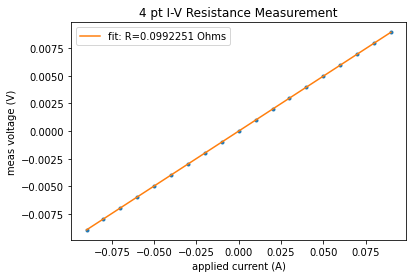

In [11]:
ChV = OutputChannel('V')
ChV.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

Progress: [####################] 100.0%
elapsed time = 122.67431712150574


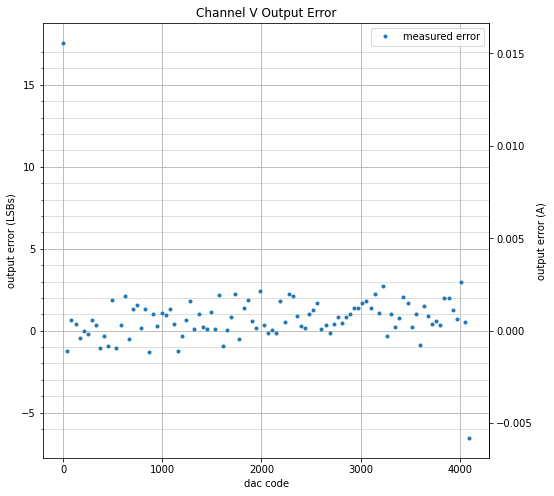

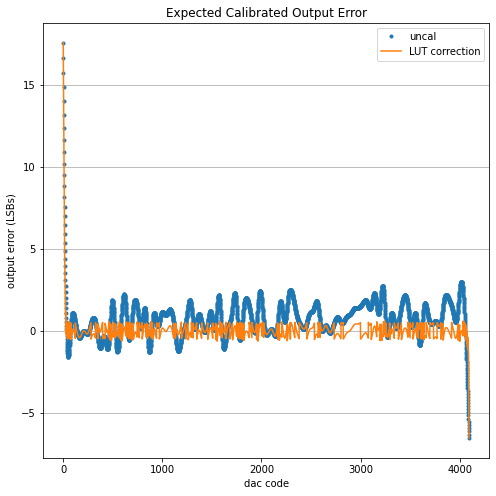

In [12]:
testCodes = np.linspace(0, ChV.numCodes-1, 100, dtype=int)
V_V = ChV.MeasVoltageVsDacCode(testCodes)
ChV.PlotCurrentError(testCodes, V_V)

ChV.CreateLUT(testCodes, V_V)
ChV.ApplyLUTCorrection()

In [55]:
ChV.EvaluatePassFail(testCodes, V_V)

rms error = 2.216 LSBs
Calibration Passed!


True

In [52]:
def DownloadLUT():
    lut = np.zeros(4096)
    for i in range(len(lut)):
        lut[i] = int(serialQry(sr542, f'$DAC? CHV, {i}'))
        
    return lut

In [53]:
lut = DownloadLUT()

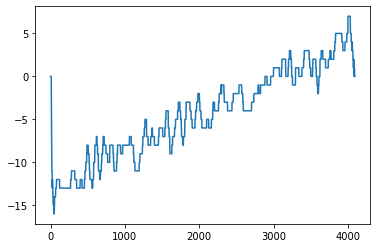

In [54]:
plt.plot(lut - ChV.LUT)

In [24]:
ChV.LUT

array([   0,    0,    0, ..., 4095, 4095, 4095], dtype=int16)

In [20]:
# Full-scale current, in Amps
(max(ChV.txFun) - min(ChV.txFun))/2

1.8040476503594416

In [23]:
ChV.HowlandGain*ChV.Vref/2

1.8151815181518152

# Experimental Verification of the Calibration

Before actually uploading the 4096-element LUT to the controller, can simulate a calibrated DAC by commanding codes that have been corrected by the LUT

Progress: [####################] 100.0%
elapsed time = 126.2588279247284


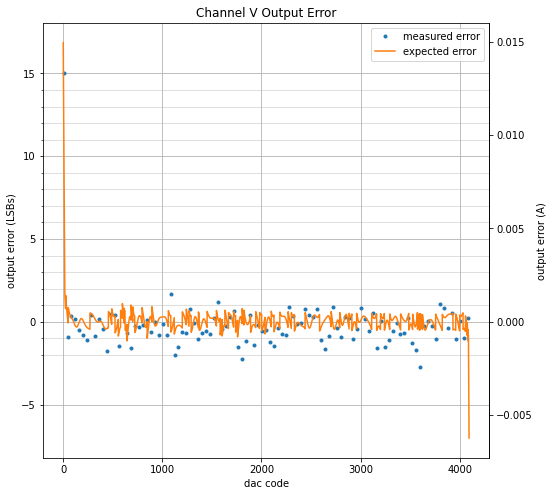

In [20]:
verifyCodes = np.arange(3, ChV.numCodes-1, 40, dtype=int)
V_V_corrected = ChV.MeasVoltageVsDacCode(ChV.LUT[verifyCodes])
ChV.PlotCurrentError(verifyCodes, V_V_corrected)

In [21]:
if ChV.EvaluatePassFail(verifyCodes, V_V_corrected):
    ChV.SaveCalData()

rms error = 1.733 LSBs
Calibration Passed!


## Upload LUTs to SR542

In [22]:
# Query LUT for Channel V, element 3
serialQry(sr542, '$DAC? CHV, 2048')

'2048'

In [23]:
ChV.LUT[2048]

2042

In [24]:
ChV.UploadCalData()

Progress: [####################] 100.0%
elapsed time = 259.5023670196533


## Verify the Uploaded LUT

In [26]:
# Define the measurement sweep
verifyCodes = np.linspace(3, ChU.numCodes-1, 200, dtype=int)
V_V_cal = ChV.MeasVoltageVsDacCode(verifyCodes)

Progress: [####################] 100.0%
elapsed time = 245.14970898628235


In [27]:
ChV.EvaluatePassFail(testCodes, V_V)

rms error = 7.146 LSBs
Calibration Failed


False

In [28]:
ChV.EvaluatePassFail(verifyCodes, V_V_cal)

rms error = 1.481 LSBs
Calibration Passed!


True

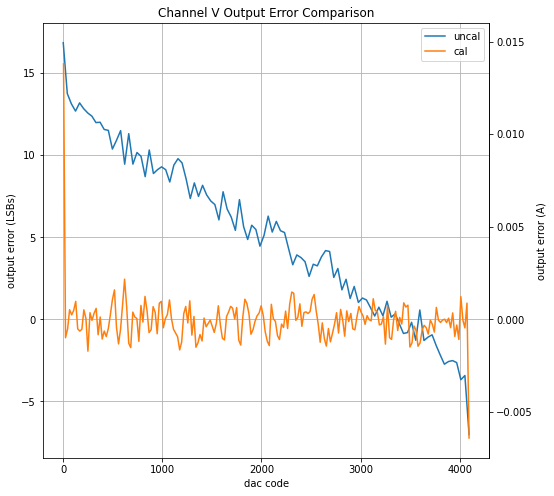

In [29]:
ChV.PlotComparison([testCodes, verifyCodes], [V_V, V_V_cal], ['uncal', 'cal'])

## Repeat the entire Cal Process for Channel U

Progress: [####################] 100.0%
R = 9.91708e-02 +- 2.01155e-05 Ohms


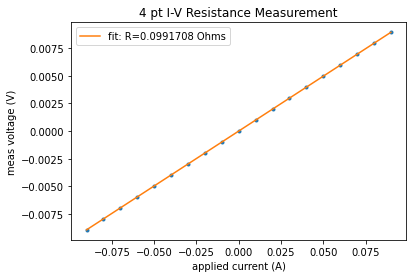

In [28]:
ChU = OutputChannel('U')
ChU.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

Progress: [####################] 100.0%
elapsed time = 122.44384980201721


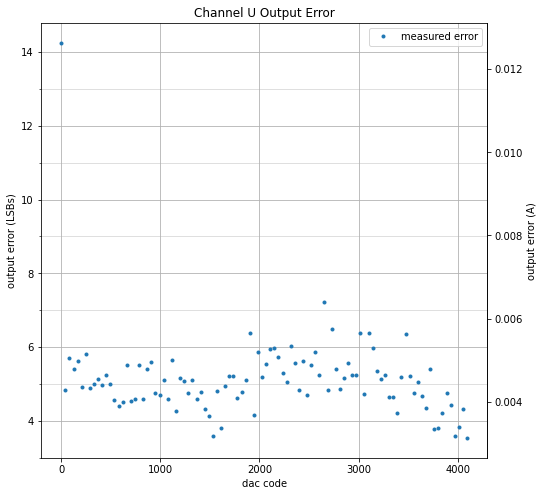

In [29]:
testCodes = np.linspace(0, ChU.numCodes-1, 100, dtype=int)
V_U_upSweep = ChU.MeasVoltageVsDacCode(testCodes)
ChU.PlotCurrentError(testCodes, V_U_upSweep)

Progress: [####################] 100.0%
elapsed time = 122.50920629501343


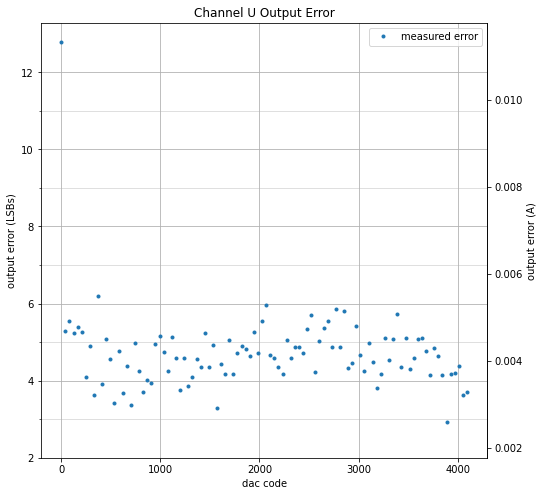

In [30]:
V_U_dnSweep = ChU.MeasVoltageVsDacCode(np.flip(testCodes))
ChU.PlotCurrentError(testCodes, np.flip(V_U_dnSweep))

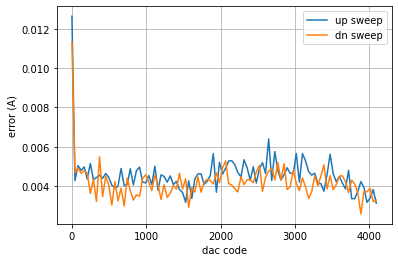

In [31]:
plt.plot(testCodes, V_U_upSweep/ChU.R - ChU.idealCurrent(testCodes), label='up sweep')
plt.plot(testCodes, np.flip(V_U_dnSweep)/ChU.R - ChU.idealCurrent(testCodes), label='dn sweep')
plt.legend()
plt.xlabel('dac code')
plt.ylabel('error (A)')
plt.grid()

In [21]:
ChU.R

0.09924126450771942

Progress: [####################] 100.0%
elapsed time = 259.0942163467407


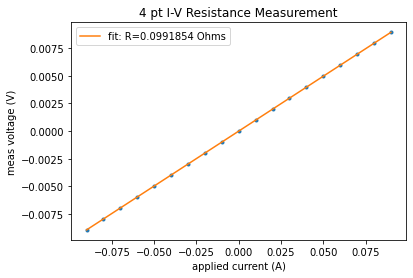

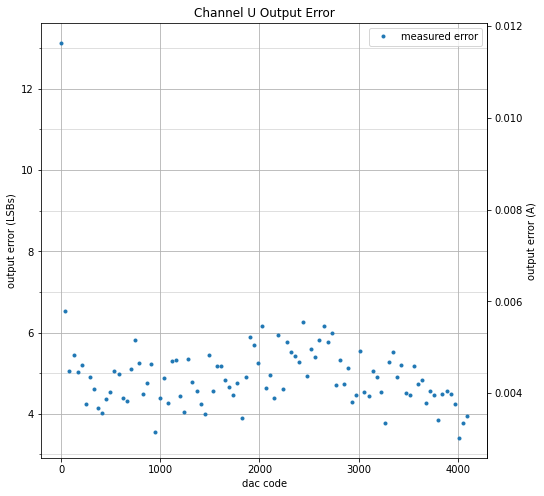

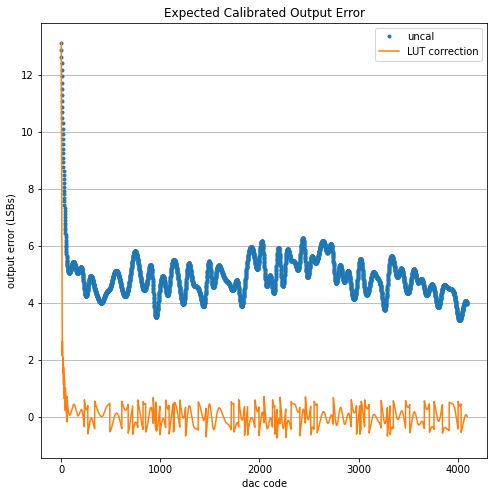

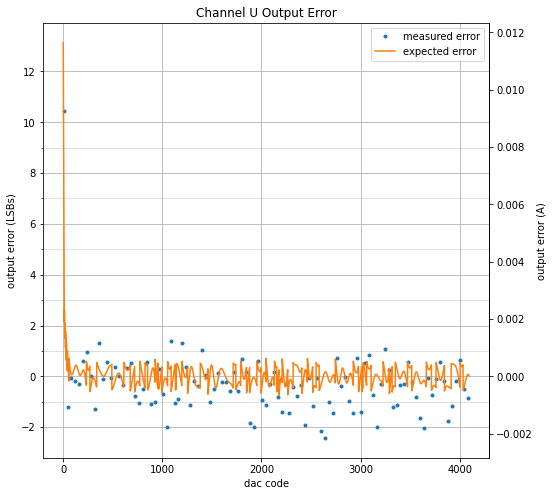

In [7]:
ChU = OutputChannel('U')
ChU.SweepI_MeasV(-90e-3, 90e-3, 10e-3)

testCodes = np.linspace(0, ChU.numCodes-1, 100, dtype=int)
V_U = ChU.MeasVoltageVsDacCode(testCodes)
ChU.PlotCurrentError(testCodes, V_U)

ChU.CreateLUT(testCodes, V_U)
ChU.ApplyLUTCorrection()

verifyCodes = np.arange(3, ChU.numCodes-1, 40, dtype=int)
V_U_corrected = ChU.MeasVoltageVsDacCode(ChU.LUT[verifyCodes])
ChU.PlotCurrentError(verifyCodes, V_U_corrected)

if ChU.EvaluatePassFail(verifyCodes, V_U_corrected):
    ChU.SaveCalData()
    ChU.UploadCalData()

In [8]:
ChU.EvaluatePassFail(verifyCodes, V_U_corrected)

rms error = 1.396 LSBs
Calibration Passed!


True

In [9]:
ChU.LUT[1111]

1106

In [10]:
serialQry(sr542, '$DAC? CHU, 1111')

'1106'

In [11]:
ChU.passed

True

## Verify the uploaded LUTs

In [12]:
# Define the measurement sweep
verifyCodes = np.linspace(3, ChU.numCodes-1, 200, dtype=int)

V_U_cal = ChU.MeasVoltageVsDacCode(verifyCodes)

Progress: [####################] 100.0%
elapsed time = 245.25027894973755


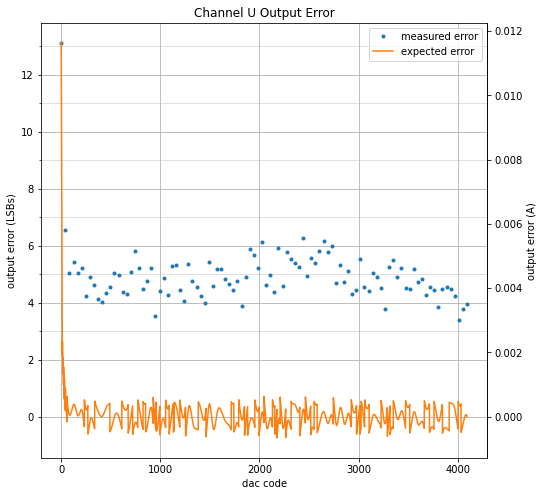

In [13]:
ChU.PlotCurrentError(testCodes, V_U)

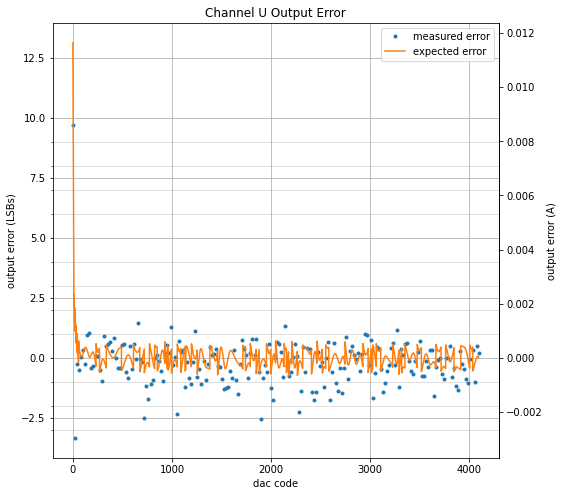

In [14]:
ChU.PlotCurrentError(verifyCodes, V_U_cal)

In [15]:
ChU.EvaluatePassFail(testCodes, V_U)

rms error = 5.057 LSBs
Calibration Failed


False

In [16]:
ChU.EvaluatePassFail(verifyCodes, V_U_cal)

rms error = 1.082 LSBs
Calibration Passed!


True

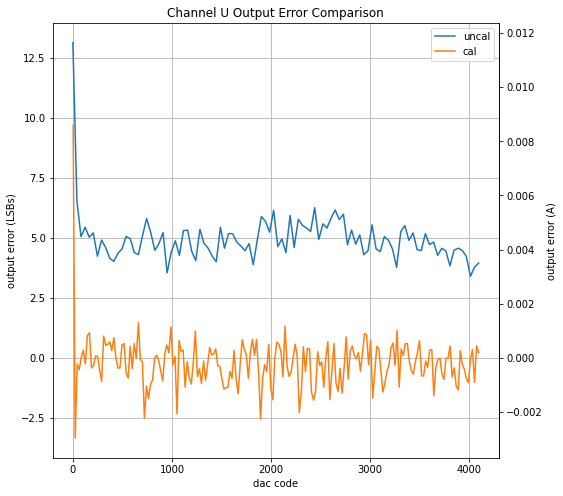

In [17]:
ChU.PlotComparison([testCodes, verifyCodes], [V_U, V_U_cal], ['uncal', 'cal'])

In [9]:
ChV.txFun

NameError: name 'ChV' is not defined

# Store Uploaded LUTs to controller NVM

In [31]:
serialCmd(sr542, '$DCN')

# TODO: This should probably be a separate command for ChU and ChU (i.e. accept channel as a command parameter)

In [7]:
serialQry(sr542, '$DAC? CHU, 2048')

'2043'

# Need to test reproducibility?

In [143]:
# Test repeatability
numTrials = 3

V = []
for i in range(numTrials):
    V.append(MeasCurrVsDacCode(testCodes, channel='V'))